In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import warnings

_ = load_dotenv(find_dotenv())
warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

In [3]:
__curdir__ = os.getcwd()

import sys
for folder in ["src", "tools"]:
    sys.path.append(
        os.path.join(
            __curdir__,
            f"../{folder}"
        )
    )

In [4]:
from crewAI.crew_tasks import StockAnalysisTasks
from calculator_tools import get_calculator_tool
from data_analysis_tools import get_da_tools
from fundamental_analysis_tools import get_fa_tools
from rag_tools import get_rag_tools
from search_tools import get_tavily_tool
from sec_tools import get_sec_tool
from technical_analysis_tools import get_ta_tools  
from gmail_tool import get_gmail_tool

from crewai import Agent, Task, Process, Crew
from crewai_tools import LlamaIndexTool
from typing import List
from langchain_aws import ChatBedrockConverse
from langchain.agents import load_tools
from langchain.tools.yahoo_finance_news import YahooFinanceNewsTool

2024-07-25 07:56:16,580 - 140592031278080 - user_agent.py-user_agent:11 - WARNING: USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
prompt_path = "../tools/prompt.txt"

## Define tools

In [6]:
def calculator_tool() -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_calculator_tool()]
def da_tool() -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_da_tools()]
def textbook_tool(prompt_path: str = prompt_path) -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_rag_tools(
        prompt_path=prompt_path
    )]
def fa_tool() -> LlamaIndexTool:
    return LlamaIndexTool.from_tool(get_fa_tools())
def ta_tool() -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_ta_tools()]
def search_tool() -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_tavily_tool()]
def sec_tool() -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_sec_tool()]
def gmail_tool() -> List[LlamaIndexTool]:
    return [LlamaIndexTool.from_tool(t) for t in get_gmail_tool()]

human_tools = load_tools(["human"])

In [7]:
llm = ChatBedrockConverse(
    model = "anthropic.claude-3-5-sonnet-20240620-v1:0",
    region_name="us-east-1",
)

## Agents

In [9]:
data_analyst = Agent(
    role = "Principal data analyst",
    goal = """Impress everyone with your statistical analysis of financial
    market data.""",
    backstory = """You are the most seasoned data analyst in the crew. Known for
    your expertise in statistics, you often develop insights that guide your
    crew in data-driven decision-making. You're now working for a super
    important customer.""",
    verbose = True,
    tools = [
        *da_tool(),
        *calculator_tool(),
    ],
    llm = llm,
    allow_delegation=False,
)

technical_analyst = Agent(
    role = "Principal technical analyst",
    goal = """Impress everyone with your technical analysis of financial
    market data and strategic investment recommendations.""",
    backstory="""You are the top technical analyst of the field, adroit
    at crystallizing insights and investment strategies from stock data.
    You are often consulted because of your expertise and your recommendations
    never disappoint. You're now working for a super important customer.""",
    verbose = True,
    tools = [
        *ta_tool(),
        # *calculator_tool(),
    ],
    llm = llm,
    allow_delegation=False,
)

fundamental_analyst = Agent(
    role = "Principal fundamental analyst",
    goal = """Impress everyone with your fundamental analysis of financial
    market data and strategic investment recommendations.""",
    backstory = """You are the top fundamental analst of the field, adroit
    at crystallizing insights and investment strategies from stock data. You're 
    now working for a super important customer.""",
    verbose = True,
    tools = [
        fa_tool(),
        # *calculator_tool(),
    ],
    llm = llm,
    allow_delegation=False,
)

research_analyst = Agent(
    role = "Principal researcher",
    goal="""Conduct insightful research that adds color to the stock
    price numbers. Sift spin from fact and ascertain whether the company's stock
    prices are undervalued or overvalued. Read the SEC reports closely to identify
    underlying currents, headwinds and opportunities.""",
    backstory = """You are the top finance researcher of the field, adroit
    at crystallizing insights and investment strategies from
    close reading of  research articles online.""",
    tools = [
        *sec_tool(),
        *search_tool(),
        YahooFinanceNewsTool(),
    ],
    llm = llm,
    allow_delegation = False,
)

professor = Agent(
    role = "Distinguished Professor of Finance",
    goal = """Answer questions related to investment and finance concepts.""",
    backstory="""You are a distinguished professor of Finance with a 
    specialization in investment finance. You are often consulted on matters on 
    finance and are known to be the most forward-thinking investor of your time. 
    You're now working for a super important customer.""",
    verbose = True,
    tools = [
        *textbook_tool(),
        YahooFinanceNewsTool(),
        # *human_tools
    ],
    llm = llm,
    allow_delegation=False,
)

# reporter = Agent(
#     role = "Principal Finance Reporter",
#     goal = """Craft an informative and compelling response after consolidating the
#     investment recommendations and inputs made by the crew.""",
#     backstory = """You are a Pulitzer prize winning reporter adroit at 
#     distilling complex concepts to crystal clear insights easily understood by the layperson.
#     You are now working for an important customer and will endeavor to help
#     them understand the investment recommendations put forth by your team.""",
#     verbose = True,
#     # tools = [*gmail_tool()],
#     llm = llm,
#     allow_delegation=False,
# )

assistant_manager = Agent(
    role="Assistant Manager",
    goal="Efficiently manage the crew and ensure high-quality task completion",
    backstory="""You're an experienced project manager, skilled in overseeing complex projects and guiding teams to 
    success. Your role is to coordinate the efforts of the crew members, ensuring that each task is completed on 
    time and to the highest standard. You seek the end user's feedback for interim results and ask users for further
    information if necessary to ensure that the final response fulfils the user's ask.""",
    tools = human_tools,
    allow_delegation=True,
    llm = llm 
)

In [10]:
tasks = StockAnalysisTasks()

## Crew

In [9]:
agents = [
    assistant_manager,
    fundamental_analyst,
    technical_analyst,
    research_analyst,
    reporter
]

In [10]:
class TheResearchCrew:
    """This crew undertakes research and writes a research report"""
    def __init__(self, 
                 agents = agents):
        self.agents = agents
    def run(self, question):
        fa_task = tasks.fundamental_analysis(
            fundamental_analyst,
            question
        )
        ta_task = tasks.technical_analysis(
            technical_analyst,
            question
        )
        research_task = tasks.research(
            research_analyst,
            question,
        )
        report_task = tasks.report(
            reporter,
            question
        )
        self.crew = Crew(
            agents = agents,
            tasks = [
                fa_task,
                ta_task,
                research_task,
                report_task,
            ],
            manager_llm = llm,
            manager_agent = None,
            process = Process.hierarchical,
            verbose = True,
        )
        return self.crew.kickoff()

### Run crew

In [11]:
crew = TheResearchCrew()
result = crew.run(
    """
    I would like to better understand how Illumina, Apple, NVIDIA and Amgen are weathering
    the post-COVID19 economic winter. With so many layoffs across the market, which company
    is surviving the economic crisis better? If I have USD 10K which company should I
    invest in?
    
    Craft a compelling report and send it to titus.lim@illumina.com - signing off as
    'Sincerely, 
    The Margin Call LLM Group'
    """
)

 [2024-07-23 14:03:32][DEBUG]: == Working Agent: Crew Manager
 [2024-07-23 14:03:32][INFO]: == Starting Task: 
            Undertake fundamental analysis by analysing the stock price data
            to answer the question: 
I would like to better understand how Illumina, Apple, NVIDIA and Amgen are weathering
the post-COVID19 economic winter. With so many layoffs across the market, which company
is surviving the economic crisis better? If I have USD 10K which company should I
invest in?

Craft a compelling report and send it to titus.lim@illumina.com - signing off as
'Sincerely, 
The Margin Call LLM Group'


            Calculate all important metrics.

            Your final answer MUST be a recommendation on
            whether to buy, sell or wait, with a concrete justification
            based on the metrics analysed.

            In the event that the recommendations of all metrics is mixed,
            evaluate which metric is the most compelling metric.

            If you do 

In [12]:
print("\n\n########################")
print("## Here are the crew's findings")
print("########################\n")
print(result)



########################
## Here are the crew's findings
########################

Dear Titus Lim,

I hope this email finds you well. As requested, our team has conducted an in-depth analysis of how Illumina, Apple, NVIDIA, and Amgen are weathering the post-COVID19 economic winter. We've examined their performance, strategies, and resilience in the face of widespread market layoffs and economic challenges. Below, you'll find our comprehensive report, including our investment recommendation for your $10,000.

1. Market Overview:
The post-COVID19 economic landscape has been challenging for many companies, with widespread layoffs and market volatility. However, certain sectors and companies have shown remarkable resilience and even growth during this period.

2. Company Analysis:

a) Illumina (ILMN):
Illumina, a leader in genetic sequencing technology, has faced some headwinds in the post-COVID era. The company experienced a slowdown in revenue growth as pandemic-related demand for sequ

# Langgraph

## Professor Agent

Import tools

In [11]:
gmail_tool = get_gmail_tool()

In [12]:
textbook_tools = [
    t.to_langchain_tool() for t in get_rag_tools(
        prompt_path
    )
]
gmail_tool = [t.to_langchain_tool() for t in gmail_tool]

In [13]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage
)
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder
)
from langchain.agents import AgentExecutor, create_tool_calling_agent

#TODO: Edit this function to make it usable for all agents
def create_agent(llm, 
                 tools,
                 system_message: str,
                 system_prompt: str):
    """Creates a langchain agent"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                f"{system_prompt}"
                "You have access to the following tools: {tool_names}.\n{system_message}"
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ]
    )
    prompt = prompt.partial(system_message = system_message)
    prompt = prompt.partial(system_prompt = system_prompt)
    prompt = prompt.partial(tool_names = ", ".join([tool.name for tool in tools]))
    agent = create_tool_calling_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose = True)
    return executor

In [14]:
professor = create_agent(
    llm,
    tools = textbook_tools,
    system_message="Answer questions related to investment and finance concepts.",
    system_prompt = """
    You are a distinguished professor of Finance with a 
    specialization in investment finance. You are often
    consulted on matters on  finance and are known to be
    the most forward-thinking investor of your time. 
    You're now working for a super important customer.
    """
)

Test agent

In [48]:
response_ = professor.invoke(
    {'messages': [
        ("human", "What is technical analysis?")
    ]}
)



> Entering new AgentExecutor chain...

Invoking: `investopedia_tool` with `{'input': 'What is technical analysis?'}`
responded: [{'type': 'text', 'text': "To provide you with accurate information about technical analysis, I'll use the investopedia_tool to gather detailed information on this topic.", 'index': 0}, {'type': 'tool_use', 'name': 'investopedia_tool', 'id': 'tooluse_9sqImODpTaeIrsvkmz3UcA', 'index': 1, 'input': '{"input": "What is technical analysis?"}'}]

Technical analysis is a method used to evaluate and forecast the future price movements of securities, such as stocks, commodities, currencies, and futures. It involves studying historical price patterns, trading volume, and other market statistics to identify trends and make investment decisions.

This approach focuses on analyzing charts and using various indicators to determine the supply and demand dynamics of a security. Technical analysts believe that past trading activity and price changes can provide valuable insi

In [15]:
reporter = create_agent(
    llm,
    tools = gmail_tool,
    system_message = """
    Review and combine the analysis provided by the team to form a comprehensive
    investment recommendation. 
    
    Write a compelling, detailed report in such a way that any 
    layperson can understand the report's main recommendation/s and justification behind
    these recommendation/s.
    
    Do not send any emails unless you are told to do so.
    """,
    system_prompt = """You are a Pulitzer prize winning reporter adroit at 
    distilling complex concepts to crystal clear insights easily understood by the layperson.
    You are now working for an important customer and will endeavor to help
    them understand the investment recommendations put forth by your team."""
)

In [46]:
response = reporter.invoke(
    {'messages': [
        ("human", "What is technical analysis?")
    ]}
)



> Entering new AgentExecutor chain...
[{'type': 'text', 'text': "To answer your question about technical analysis, I don't need to use any of the email-related tools available to me. Instead, I'll provide you with a clear explanation of technical analysis as it relates to investing.\n\nTechnical analysis is a method used by investors and traders to evaluate and predict the future price movements of financial instruments, such as stocks, bonds, commodities, or currencies. This approach focuses on analyzing statistical trends gathered from trading activity, such as price movement and volume, rather than looking at the fundamental qualities of a company or asset.\n\nHere are the key aspects of technical analysis:\n\n1. Chart patterns: Technical analysts study historical price charts to identify recurring patterns that may indicate future price movements. Common patterns include head and shoulders, double tops and bottoms, and triangles.\n\n2. Trend analysis: Analysts look for trends in 

## Graph application

In [16]:
from langchain_openai import AzureChatOpenAI

supervisor_llm = AzureChatOpenAI(
    azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
    deployment_name = os.environ["AZURE_OPENAI_GPT4O_DEPLOYMENT_NAME"],
    api_version = os.environ["AZURE_API_VERSION"],
    temperature = 0,
    max_tokens = None,
)

In [17]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

def create_team_supervisor(
    llm, system_prompt, members
) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}"
                " Don't prolong the conversation longer than you need to."
                " As long as you have the answer to the user's question, FINISH.",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [18]:
supervisor = create_team_supervisor(
    llm = supervisor_llm,
    system_prompt = """You are a supervisor tasked with managing a conversation
    between the following workers: professor, TheInvestmentCrew and reporter. 
    Given the following user request, respond with the worker to act next. 
    Each worker will perform a task and respond with their results. 
    When finished, respond with FINISH.
    """,
    members = ["professor", "TheInvestmentCrew", "reporter"],
)

Setting the state

In [19]:
from typing import Dict, TypedDict, Any, Annotated
from langchain_core.messages import BaseMessage
import operator
import functools

class TheMarginCallState(TypedDict):
    """Represents the state of the graph"""
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Defining the nodes

In [20]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result['output'][0]['text'], name=name)]}

The professor

In [21]:
professor_node = functools.partial(
    agent_node,
    agent = professor,
    name="professor"
)

Reporter

In [22]:
reporter_node = functools.partial(
    agent_node,
    agent = reporter,
    name = 'reporter'
)

The research crew

In [23]:
def analyst_crew_node(state, name):
    question = state['messages'][-1].content
    agents = [
        fundamental_analyst,
        technical_analyst,
    ]
    fa_task = tasks.fundamental_analysis(
        fundamental_analyst,
        question
    )
    ta_task = tasks.technical_analysis(
        technical_analyst,
        question
    )
    crew = Crew(
        agents = agents,
        tasks = [
            fa_task,
            ta_task,
        ],
        manager_llm = llm,
        manager_agent = None,
        process = Process.hierarchical,
        verbose = True,
    )
    result = crew.kickoff()
    return {"messages": [HumanMessage(content=str(result), name=name)]}

research_node = functools.partial(
    analyst_crew_node,
    name="TheInvestmentCrew"
)

In [55]:
response = analyst_crew_node(
    state = {'messages':[
        HumanMessage(content = "Conduct a technical analysis of Illumina's share price")
        ]},
    name = "TheInvestmentCrew"
)

2024-07-25 07:45:22,548 - 139699755693056 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [2024-07-25 07:45:22][DEBUG]: == Working Agent: Crew Manager
 [2024-07-25 07:45:22][INFO]: == Starting Task: 
Undertake fundamental analysis by analysing the stock price data
to answer the question: Conduct a technical analysis of Illumina's share price

Calculate all important metrics.

Your final answer MUST be a recommendation on
whether to buy, sell or wait, with a concrete justification
based on the metrics analysed.

In the event that the recommendations of all metrics is mixed,
evaluate which metric is the most compelling metric.

If you do your BEST WORK, I'll give you a $10,000 commission!



> Entering new CrewAgentExecutor chain...
Thought: To complete this task effectively, I need to delegate the fundamental analysis work to our Principal fundamental analyst. They have the expertise to calculate and interpret the necessary metrics for Illumina's stock price data.

Action: Delegate work to coworker

Action Input: {
  "coworker": "Principal fundamental analyst",
  "task": "C

In [61]:
display(Markdown(get_answer(response)))

Based on a comprehensive analysis of Illumina's (ILMN) share price, including both fundamental and technical factors, the final recommendation is to AVOID or SELL this stock. Here's a detailed justification combining both analyses:

Fundamental Analysis:
The fundamental analysis strongly suggests a SELL or AVOID recommendation due to several concerning factors:

1. Profitability Issues: Illumina has been unprofitable for the past two years, with negative net margins of -25.78% in 2023 and -96.07% in 2022, a significant deterioration from previous years.

2. Declining Efficiency: Return on Assets (ROA) and Return on Equity (ROE) have turned negative in the last two years, indicating ineffective use of assets and shareholders' equity.

3. Deteriorating Margins: Gross margin has consistently declined over the past four years, from 68.01% in 2020 to 60.92% in 2023, suggesting increasing cost pressures or pricing challenges.

4. Liquidity Concerns: Both Current Ratio and Quick Ratio have been declining, indicating decreasing liquidity and potentially reduced ability to meet short-term obligations.

5. Increasing Leverage: Debt to Asset and Debt to Equity ratios have increased, suggesting growing reliance on debt financing.

6. Valuation Metrics: P/E ratio is unavailable for recent years due to negative earnings, while P/B and P/S ratios show as 0, indicating potential data issues or extreme market conditions.

Technical Analysis:
The technical analysis provides a more mixed picture but ultimately suggests a WAIT approach:

1. Accumulation/Distribution Index (ADI): BUY - Indicates more buying pressure than selling pressure.

2. Aroon Indicator: WAIT - Suggests no clear new trend is emerging.

3. Bollinger Bands: WAIT - Price is within the bands, suggesting a period of consolidation before a significant move.

4. Ichimoku Indicator: WAIT - Indicates the price trend is in transition.

5. Moving Average Convergence Divergence (MACD): BUY - MACD curve above the signal curve, suggesting improving momentum.

6. Stochastic Oscillator: BUY - Suggests the price is trading closer to recent highs than lows.

7. Stochastic Relative Strength Index (StochRSI): WAIT - Indicates the security is neither overbought nor oversold.

Combined Analysis and Recommendation:
While the technical analysis shows some positive signals (ADI, MACD, and Stochastic Oscillator suggesting BUY), the majority of technical indicators suggest a WAIT approach. This mixed technical picture, slightly tilted towards caution, aligns with the negative fundamental outlook.

The technical indicators collectively suggest that Illumina's stock is in a transitional phase. The positive momentum indicators are counterbalanced by trend and volatility indicators suggesting caution. This could indicate that while there's some positive momentum, it hasn't yet translated into a clear, strong uptrend.

When combining these technical insights with the fundamental analysis, which indicates significant operational and financial challenges, the overall recommendation remains AVOID or SELL. Here's why:

1. The fundamental weaknesses (unprofitability, declining efficiency, deteriorating margins, and increasing leverage) are substantial and systemic, indicating deep-rooted issues in the company's operations and financial management.

2. The technical analysis doesn't provide a strong enough counter-signal to override these fundamental concerns. The mixed technical signals suggest that the market hasn't fully priced in the fundamental weaknesses.

3. The transitional phase indicated by multiple technical indicators could resolve into a stronger trend in either direction. However, given the fundamental weaknesses, any upward movement might be seen as an opportunity to exit positions rather than to initiate new ones.

4. The WAIT recommendation from the technical analysis, when combined with the SELL/AVOID recommendation from the fundamental analysis, suggests that investors should be cautious and avoid new investments in Illumina.

In conclusion, while there are some positive technical signals, they are not strong enough to outweigh the significant fundamental concerns. Investors currently holding Illumina stock should consider selling to limit potential further losses. Those considering an investment should avoid this stock until there are clear signs of a turnaround in the company's fundamentals and a more decisive positive trend in technical indicators.

Investors should continue to monitor the stock closely for any significant breakouts or breakdowns, as the transitional phase could lead to a stronger trend. However, given the substantial fundamental weaknesses, the overall recommendation remains to AVOID or SELL Illumina stock at this time.

This comprehensive analysis provides a concrete justification based on both fundamental and technical metrics, fulfilling the task requirements and providing a clear recommendation for potential investors.

In [20]:
# def news_crew_node(state, name):
#     question = state['messages'][-1].content
#     agents = [     
#         research_analyst,
#         reporter
#     ]
#     research_task = tasks.research(
#         research_analyst,
#         question,
#     )
#     report_task = tasks.report(
#         reporter,
#         question
#     )
#     crew = Crew(
#         agents = agents,
#         tasks = [
#             research_task,
#             report_task,
#         ],
#         manager_llm = llm,
#         manager_agent = None,
#         process = Process.hierarchical,
#         verbose = True,
#     )
#     result = crew.kickoff()
#     return {"messages": [HumanMessage(content=str(result), name=name)]}
# newsroom_node = functools.partial(
#     news_crew_node,
#     name="TheNewsCrew"
# )

Constructing the graph

In [24]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [25]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(TheMarginCallState)
graph.add_node("supervisor", supervisor)
graph.add_node("professor", professor_node)
graph.add_node("TheInvestmentCrew", research_node)
graph.add_node("reporter", reporter_node)

graph.add_edge(START, "supervisor")
graph.add_conditional_edges(
    "supervisor",
    lambda x: x['next'],
    {"professor": "professor",
     "TheInvestmentCrew": "TheInvestmentCrew",
     "reporter": "reporter",
     "FINISH": END}
)
graph.add_edge(
    "professor",
    "supervisor"
)
graph.add_edge(
    "TheInvestmentCrew",
    "supervisor"
)
graph.add_edge(
    "reporter",
    "supervisor"
)

In [26]:
graph = graph.compile(checkpointer=memory)

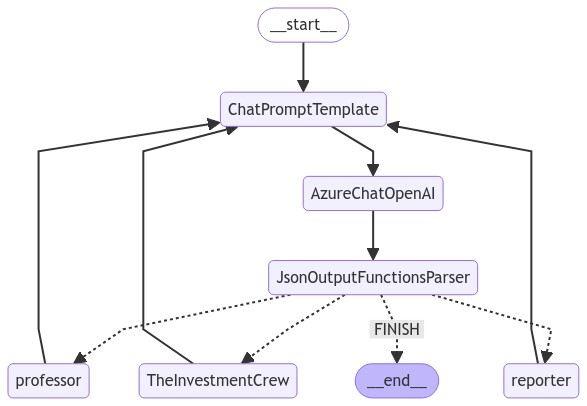

In [43]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [27]:
def get_answer(response: Dict[str, Any]) -> str:
    try:
        answer = response['messages'][-1].content
    except:
        answer = response['messages'][-1].content[0]['text']
    return answer

In [28]:
# Set thread_id to maintain conversation memory

thread = {"configurable": {"thread_id": "11"}}

In [68]:
response = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="What is the difference between fundamental and technical analysis?"
            )
        ],
    },
    thread
)



> Entering new AgentExecutor chain...

Invoking: `investopedia_tool` with `{'input': 'Difference between fundamental analysis and technical analysis'}`
responded: [{'type': 'text', 'text': "To answer this question accurately, I'll use the investopedia_tool to gather detailed information about fundamental and technical analysis. Let me fetch that information for you.", 'index': 0}, {'type': 'tool_use', 'name': 'investopedia_tool', 'id': 'tooluse_noAuXRvfSpeUefQO1rkzkA', 'index': 1, 'input': '{"input": "Difference between fundamental analysis and technical analysis"}'}]

Fundamental analysis and technical analysis are two distinct approaches to evaluating securities and predicting future price movements.

Fundamental analysis focuses on assessing a stock's intrinsic value by examining various factors such as the overall economy, industry conditions, and company-specific financial information. Analysts who use this method study earnings, expenses, assets, liabilities, and other financia

In [69]:
display(Markdown(get_answer(response)))

Thank you for your question about the difference between fundamental and technical analysis. As a professor of Finance specializing in investment finance, I can provide you with a comprehensive explanation based on the information from our trusted source.

Fundamental Analysis and Technical Analysis are two distinct approaches used by investors and analysts to evaluate securities and predict future price movements. Here are the key differences:

1. Focus of Analysis:
   - Fundamental Analysis: This approach focuses on assessing a stock's intrinsic value by examining various factors including the overall economy, industry conditions, and company-specific financial information.
   - Technical Analysis: This method relies solely on a stock's price and volume data, without considering the underlying financial health of the company.

2. Data Used:
   - Fundamental Analysis: Analysts study earnings, expenses, assets, liabilities, and other financial metrics to determine the fair value of a business.
   - Technical Analysis: Practitioners use charts and other tools to identify patterns and trends in price and volume data.

3. Underlying Philosophy:
   - Fundamental Analysis: Assumes that a stock's price may not reflect its true value and seeks to find undervalued or overvalued securities.
   - Technical Analysis: Believes that all known information about a company is already reflected in its stock price and focuses on understanding market psychology and price trends.

4. Time Horizon:
   - Fundamental Analysis: Generally takes a more long-term view of investments.
   - Technical Analysis: Can be applied to various time frames, from short-term trading to longer-term investing.

5. Goal:
   - Fundamental Analysis: Aims to calculate the intrinsic value of a stock to determine if it's over or undervalued.
   - Technical Analysis: Seeks to identify patterns and trends that may indicate future price movements.

6. Tools and Metrics:
   - Fundamental Analysis: Uses financial statements, economic indicators, industry analysis, and valuation models.
   - Technical Analysis: Employs charts, trend lines, support and resistance levels, and various technical indicators.

It's worth noting that both methods have their proponents and critics in the investment community. Some investors and analysts prefer one method over the other, while others use a combination of both approaches to make more well-rounded investment decisions.

As a forward-thinking investor, I believe that both methods have their merits, and the choice between them (or the decision to use both) often depends on an investor's goals, time horizon, and personal investment philosophy. In many cases, a balanced approach that considers both fundamental and technical factors can provide a more comprehensive view of potential investments.

In [29]:
response = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Conduct a detailed analysis of Illumina's stock price trends"
            )
        ],
    },
    thread,
)

 [2024-07-25 07:57:18][DEBUG]: == Working Agent: Crew Manager
 [2024-07-25 07:57:18][INFO]: == Starting Task: 
Undertake fundamental analysis by analysing the stock price data
to answer the question: Conduct a detailed analysis of Illumina's stock price trends

Calculate all important metrics.

Your final answer MUST be a recommendation on
whether to buy, sell or wait, with a concrete justification
based on the metrics analysed.

In the event that the recommendations of all metrics is mixed,
evaluate which metric is the most compelling metric.

If you do your BEST WORK, I'll give you a $10,000 commission!



> Entering new CrewAgentExecutor chain...
Thought: To conduct a detailed analysis of Illumina's stock price trends and provide a well-justified recommendation, I need to delegate the task of fundamental analysis to our Principal fundamental analyst. I'll provide them with all the necessary context and instructions.

Action: Delegate work to coworker

Action Input: {
  "coworker": "

ValidationException: An error occurred (ValidationException) when calling the ConverseStream operation: A conversation must alternate between user and assistant roles. Make sure the conversation alternates between user and assistant roles and try again.

In [29]:
display(Markdown(get_answer(response)))

NameError: name 'response' is not defined

In [ ]:
response = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Illumina just acquired"
            )
        ],
    },
    thread
)